# Inference Script

**Author:** Prisca Dotti

**Last modified:** 12.02.2024

Use this script to load a sample movie and run preprocessing suggested in "A New Approach to the Detection and Statistical Classification of Ca2+ Sparks", by Bányász et al.

Two ideas:
1. only apply filtering to movies + cell mask to annotations and train U-Net again
2. Apply whole algorithm to cell to detect sparks and then find a way to compare them automatically with our annotations & re-train U-Net


### Conclusions

After implementing and running the script, it appears that the script is not working as expected. The ground truth contains 69 true sparks, but the script is not able to detect all of them accurately.

Possible reasons for the discrepancy between the expected and actual results could be:

1. Noisy sample: preprocess and better denoise sample (but then again it is not fully automatic)
2. Find better thresholds
not be capturing all the relevant characteristics of sparks. Exploring alternative feature extraction techniques or incorporating additional features could potentially enhance the accuracy of spark detection.
3. Find better statistical tests

In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
# To import modules from parent directory in Jupyter Notebook
import sys

sys.path.append("..")

In [2]:
# Required imports
import numpy as np
import imageio
import matplotlib.pyplot as plt
import napari
from scipy.ndimage import uniform_filter, convolve, median_filter, label, center_of_mass
from scipy.stats import t, wilcoxon

### Function Definitions

In [3]:
def load_movie(movie_path):
    return np.asarray(imageio.volread(movie_path))

In [4]:
def preprocess_frames(frames):
    # Assuming the first few frames can serve as a baseline for normalization
    normalizing_frame = np.median(frames[:10], axis=0)
    return frames / (normalizing_frame + 1e-6)  # Prevent division by zero

In [5]:
def apply_boxcar_filter(frames, filter_size=5):
    """
    Apply a 5x5 boxcar filter to each 2D frame in a 3D numpy array of frames.
    Attenuates objects having spatial size of <~1.um (5x pixel size of 0.2 um).

    Parameters:
    - frames: A 3D numpy array with shape (num_frames, height, width).
    - filter_size: Size of the boxcar filter, default is 5.

    Returns:
    - A 3D numpy array with the filtered frames.
    """
    # Apply the boxcar filter to each frame
    filtered_frames = np.array(
        [uniform_filter(frame, size=filter_size) for frame in frames]
    )
    return filtered_frames

In [29]:
def difference_and_threshold(frames, threshold=0.1):
    # Remark: Custom threshold based on expected Ca²⁺ event intensities
    diff_frames = np.diff(frames, axis=0)

    # flattened_data = diff_frames.flatten()
    # median_intensity = np.median(flattened_data)
    # std_intensity = np.std(flattened_data)

    # dynamic_threshold = median_intensity + (2 * std_intensity)
    # print("Dynamic threshold: ", dynamic_threshold)

    thresholded_frames = np.append(
        (diff_frames > threshold).astype(np.uint8),
        # (diff_frames > dynamic_threshold).astype(np.uint8),
        np.zeros_like(frames[:1]),  # Add missing frame at the end
        axis=0,
    ).astype(np.uint8)

    # Repeat the last frame to match the number of frames
    diff_frames = np.concatenate([diff_frames, diff_frames[-1:]], axis=0)

    return diff_frames, thresholded_frames

In [13]:
def live_or_die_filter_frame(binary_image, n_size=7, n_live=12, n_generation=3):
    """
    Applies the "live-or-die" algorithm to a binary image.

    From: "Theoretical analysis of the Ca2+ spark amplitude distribution" by
    Izu, L.T., et al. (1998)

    Parameters:
    - binary_image: A 2D numpy array where potential spark pixels are marked as
                    1 and all others as 0.
    - n_size: Size of the square neighborhood.
    - n_live: Minimum number of live neighbors required for a pixel to survive.
    - n_generation: Number of iterations the algorithm runs for.

    Returns:
    - A 2D numpy array after applying the "live-or-die" filtering.
    """
    # Create a square kernel of size Nsize x n_size for boxcar averaging
    kernel = np.ones((n_size, n_size), dtype=np.float32)
    for _ in range(n_generation):
        # Perform boxcar averaging
        neighbor_count = convolve(
            binary_image.astype(np.float32), kernel, mode="constant", cval=0
        )
        # Apply thresholding based on n_live
        binary_image = neighbor_count >= n_live
    return binary_image


def live_or_die_filter(binary_movie, n_size=4, n_live=7, n_generation=3):
    """
    Applies the "live-or-die" algorithm to a 3D binary movie.

    Parameters:
    - binary_movie: A 3D numpy array where potential spark pixels are marked as
                    1 and all others as 0.
    - n_size: Size of the square neighborhood.
    - n_live: Minimum number of live neighbors required for a pixel to survive.
    - n_generation: Number of iterations the algorithm runs for.

    Returns:
    - A 3D numpy array after applying the "live-or-die" filtering.
    """
    filtered_movie = np.zeros_like(binary_movie)

    for i, frame in enumerate(binary_movie):
        filtered_movie[i] = live_or_die_filter_frame(
            frame, n_size, n_live, n_generation
        )

    return filtered_movie

In [14]:
def detect_inside_cell(normalizing_frame, n_size=7, n_live=3, n_generation=1):
    """
    Detects the inside of the cell by creating a binary image based on the median
    threshold and refining it using the live-or-die algorithm.

    Parameters:
    - normalizing_frame: A 2D numpy array representing the normalizing frame.
    - Nsize: Size of the neighborhood for the live-or-die algorithm.
    - Nlive: Minimum number of "live" neighbors for a pixel to be considered inside the cell.
    - Ngeneration: Number of iterations for the live-or-die algorithm.

    Returns:
    - A binary 2D numpy array representing the inside of the cell.
    """
    # Step 1: Create a binary image based on the median value
    median_value = np.median(normalizing_frame)
    binary_image = normalizing_frame >= median_value
    # Apply median filter to smooth the binary image before live-or-die to reduce noise
    binary_image_smoothed = median_filter(binary_image, size=3)
    # Step 2: Refine the binary image using the live-or-die filter
    return live_or_die_filter_frame(
        binary_image_smoothed, n_size=n_size, n_live=n_live, n_generation=n_generation
    )

In [15]:
def find_sparks(movie, threshold_movie, inside_cell):
    """
    Finds the coordinates of sparks within the cell interior for a sequence of images.

    Parameters:
    - movie: A 3D numpy array representing the sequence of images.
    - threshold_movie: A binary 3D numpy array where potential sparks are marked.
    - inside_cell: A binary 2D numpy array representing the cell interior.

    Returns:
    - spark_info: A list of dictionaries, each containing the center of mass coordinates,
      spark area, and blob number for each identified spark within the cell.
    """
    spark_info = []
    for i, (frame, threshold_frame) in enumerate(zip(movie, threshold_movie)):
        # Multiply the binary images to isolate sparks within the cell interior
        binary_spark_image = np.logical_and(inside_cell, threshold_frame)

        # Label and identify each isolated spark
        labeled_image, num_features = label(binary_spark_image)

        for blob_number in range(1, num_features + 1):
            # Isolate each spark based on its label
            blob_mask = labeled_image == blob_number
            isolated_spark = frame * blob_mask

            # Calculate the center of mass for the isolated spark
            center = center_of_mass(isolated_spark, labels=blob_mask)  # y, x

            # Record spark information
            spark_area = np.sum(blob_mask)
            spark_info.append(
                {
                    "center_of_mass": center,
                    "spark_area": spark_area,
                    "blob_number": blob_number,
                    "frame_number": i,
                }
            )
    return spark_info

In [46]:
def classify_sparks(
    candidate_sparks,
    fluorescence_frames,
    threshold_a=0.01,
    threshold_b=0.025,
    n_size=3,
    pre_frames=6,
):
    """
    Classifies candidate sparks based on statistical tests.

    Parameters:
    - candidate_sparks: List of dictionaries containing spark information including 'center_of_mass' and 'frame_index'.
    - fluorescence_frames: 3D numpy array of fluorescence values with shape (num_frames, height, width).
    - threshold_a: Threshold for the probability that the fluorescence increase is due to chance (for frame k).
    - threshold_b: Threshold for the subsequent frame (k + 1).
    - n_size: Size of the neighborhood for calculating local fluorescence statistics.
    - pre_frames: Number of frames before the spark to use for calculating local fluorescence statistics.

    Returns:
    - A list of classified sparks (only those considered true sparks).
    """
    true_sparks = []
    half_n_size = n_size // 2

    for spark in candidate_sparks:
        y, x = spark["center_of_mass"]
        frame_number = spark["frame_number"]

        # Cast to int to avoid numpy indexing errors
        x, y = int(x), int(y)

        # Ensure coordinates and frame index are within bounds
        if not (
            half_n_size <= x < fluorescence_frames.shape[2] - half_n_size
            and half_n_size <= y < fluorescence_frames.shape[1] - half_n_size
        ):
            continue  # Coordinates out of bounds
        if not (pre_frames <= frame_number < fluorescence_frames.shape[0] - 1):
            continue  # Not enough frames for analysis

        # Calculate local fluorescence statistics in the neighborhood around the spark
        local_frames = fluorescence_frames[
            frame_number - pre_frames : frame_number - 1,
            y - half_n_size : y + half_n_size + 1,
            x - half_n_size : x + half_n_size + 1,
        ]
        m = np.mean(local_frames)
        s = np.std(local_frames)

        f_k = np.mean(
            fluorescence_frames[
                frame_number,
                y - half_n_size : y + half_n_size + 1,
                x - half_n_size : x + half_n_size + 1,
            ]
        )
        f_k_plus_1 = np.mean(
            fluorescence_frames[
                frame_number + 1,
                y - half_n_size : y + half_n_size + 1,
                x - half_n_size : x + half_n_size + 1,
            ]
        )

        # Calculate t-scores and p-values for frames k and k+1
        t_score_k = (f_k - m) / s if s > 0 else np.inf
        p_value_k = t.sf(
            np.abs(t_score_k), df=pre_frames - 2
        )  # df=4 because sample size is 5 (k-6 to k-2)

        t_score_k_plus_1 = (f_k_plus_1 - m) / s if s > 0 else np.inf
        p_value_k_plus_1 = t.sf(np.abs(t_score_k_plus_1), df=pre_frames - 2)

        # Apply thresholds to classify the spark
        if p_value_k < threshold_a and p_value_k_plus_1 < threshold_b:
            true_sparks.append(spark)

    return true_sparks

In [62]:
def classify_sparks_wilcoxon(
    candidate_sparks,
    fluorescence_frames,
    significance_level=0.05,
    n_size=3,
    pre_frames=6,
):
    true_sparks = []

    for spark in candidate_sparks:
        y, x = spark["center_of_mass"]
        frame_number = spark["frame_number"]
        x, y = int(x), int(y)

        # Collect pre-spark and during-spark fluorescence intensities
        pre_spark_intensities = fluorescence_frames[
            frame_number - pre_frames : frame_number - 1,
            y - n_size : y + n_size + 1,
            x - n_size : x + n_size + 1,
        ]
        pre_spark_intensities = np.mean(pre_spark_intensities, axis=0)

        during_spark_intensities = fluorescence_frames[
            frame_number : frame_number + 2,
            y - n_size : y + n_size + 1,
            x - n_size : x + n_size + 1,
        ]
        during_spark_intensities = np.mean(during_spark_intensities, axis=0)

        # Perform the Wilcoxon signed-rank test
        _, p_value = wilcoxon(
            pre_spark_intensities.flatten(),
            during_spark_intensities.flatten(),
            alternative="greater",
        )

        # Check if the p-value is less than the significance level
        if p_value < significance_level:
            true_sparks.append(spark)

    return true_sparks

In [17]:
def analyze_fluorescence_distribution(movie_data):
    """
    Analyzes the distribution of fluorescence intensity in the movie data.

    Parameters:
    - movie_data: A 3D numpy array with shape (num_frames, height, width), representing the fluorescence movie.

    Outputs:
    - Histograms of fluorescence intensity
    - Statistical summary (mean, median, standard deviation, min, and max values)
    """
    # Flatten the movie data to analyze the distribution of all pixels across all frames
    flattened_data = movie_data.flatten()

    # Calculate basic statistics
    mean_intensity = np.mean(flattened_data)
    median_intensity = np.median(flattened_data)
    std_intensity = np.std(flattened_data)
    min_intensity = np.min(flattened_data)
    max_intensity = np.max(flattened_data)

    print(f"Mean fluorescence intensity: {mean_intensity}")
    print(f"Median fluorescence intensity: {median_intensity}")
    print(f"Standard deviation of fluorescence intensity: {std_intensity}")
    print(f"Minimum fluorescence intensity: {min_intensity}")
    print(f"Maximum fluorescence intensity: {max_intensity}")

    # Plotting the histogram of fluorescence intensity
    plt.figure(figsize=(10, 6))
    plt.hist(flattened_data, bins=50, color="blue", alpha=0.7)
    plt.title("Distribution of Fluorescence Intensity")
    plt.xlabel("Fluorescence Intensity")
    plt.ylabel("Frequency")
    plt.axvline(
        mean_intensity,
        color="r",
        linestyle="dashed",
        linewidth=1,
        label=f"Mean: {mean_intensity:.2f}",
    )
    plt.axvline(
        median_intensity,
        color="g",
        linestyle="dashed",
        linewidth=1,
        label=f"Median: {median_intensity:.2f}",
    )
    plt.legend()
    plt.show()

### Script Execution Flow

In [18]:
# Define the path to your movie file
# movie_path = r"C:\Users\prisc\Code\sparks_project\data\sparks_dataset\05_video.tif"
movie_path = r"C:\Users\dotti\Code\sparks_project\data\sparks_dataset\20_video.tif"
# movie_path = r"C:\Users\dotti\Desktop\cropped 34_video.tif"
# shape is (904, 53, 284)

# Load the movie
movie_data = load_movie(movie_path)
print("Movie shape: ", movie_data.shape)

Movie shape:  (500, 64, 512)


In [19]:
# Filter the movie
normalized_movie = preprocess_frames(movie_data)
filtered_movie = apply_boxcar_filter(normalized_movie)
print("Normalized movie shape: ", normalized_movie.shape)
print("Max value in normalized movie: ", np.max(normalized_movie))
print("Min value in normalized movie: ", np.min(normalized_movie))
print("Filtered movie shape: ", filtered_movie.shape)
print("Max value in filtered movie: ", np.max(filtered_movie))
print("Min value in filtered movie: ", np.min(filtered_movie))

Normalized movie shape:  (500, 64, 512)
Max value in normalized movie:  5.022815531542323
Min value in normalized movie:  0.377459342616006
Filtered movie shape:  (500, 64, 512)
Max value in filtered movie:  3.067690480471482
Min value in filtered movie:  0.7066578265137713


In [30]:
# Get the difference and thresholded movies
threshold = 0.25
diff_movie, threshold_movie = difference_and_threshold(
    filtered_movie, threshold=threshold
)
print("Thresholded movie shape: ", threshold_movie.shape)
print(
    "Number of nonzero values in thresholded movie: ", np.count_nonzero(threshold_movie)
)
print("Difference movie max: ", diff_movie.max())
print("Difference movie min: ", diff_movie.min())

Thresholded movie shape:  (500, 64, 512)
Number of nonzero values in thresholded movie:  28151
Difference movie max:  0.864963773234166
Difference movie min:  -0.5180579952096034


In [31]:
# Run the live-or-die filter on the thresholded movie
n_size = 4
n_live = 7
n_generation = 3
filtered_threshold_movie = live_or_die_filter(
    threshold_movie, n_size, n_live, n_generation
).astype(np.uint8)
print("Filtered thresholded movie shape: ", filtered_threshold_movie.shape)
print(
    "Number of nonzero values in filtered thresholded movie: ",
    np.count_nonzero(filtered_threshold_movie),
)

Filtered thresholded movie shape:  (500, 64, 512)
Number of nonzero values in filtered thresholded movie:  14543


Inside cell shape:  (64, 512)
Normalizing frame:


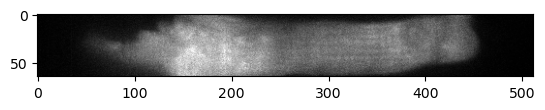

Inside cell:


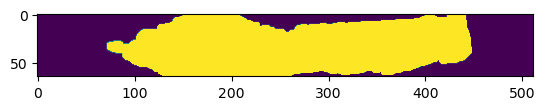

In [32]:
# Compute cell mask
normalizing_frame = np.median(movie_data[:10], axis=0)
inside_cell = detect_inside_cell(normalizing_frame, n_size=7, n_live=3, n_generation=1)
print("Inside cell shape: ", inside_cell.shape)
print("Normalizing frame:")
plt.imshow(normalizing_frame, cmap="gray")
plt.show()
print("Inside cell:")
plt.imshow(inside_cell)
plt.show()

In [33]:
# Get sparks candidates
spark_coordinates = find_sparks(filtered_movie, filtered_threshold_movie, inside_cell)
print(f"Number of sparks: {len(spark_coordinates)}")
print("Example of spark coordinates:\n", spark_coordinates[0])

Number of sparks: 472
Example of spark coordinates:
 {'center_of_mass': (10.488842597624009, 435.5018756710095), 'spark_area': 4, 'blob_number': 1, 'frame_number': 3}


In [47]:
# Filter sparks according to statistical tests
pre_frames = 19  # adapted to our dataset
threshold_a = 0.05
threshold_b = 0.1
true_sparks = classify_sparks(
    candidate_sparks=spark_coordinates,
    fluorescence_frames=normalized_movie,
    pre_frames=pre_frames,
    threshold_a=threshold_a,
    threshold_b=threshold_b,
)
print(f"Detected {len(true_sparks)} true Ca²⁺ sparks.")
print("Example of true spark:\n", true_sparks[0])

Detected 14 true Ca²⁺ sparks.
Example of true spark:
 {'center_of_mass': (15.404361822051289, 431.5110502281297), 'spark_area': 27, 'blob_number': 1, 'frame_number': 169}


In [70]:
# Filter sparks according to the Wilcoxon signed-rank test
pre_frames = 10
significance_level = 0.15
n_size = 3
true_sparks_wilcoxon = classify_sparks_wilcoxon(
    candidate_sparks=spark_coordinates,
    fluorescence_frames=normalized_movie,
    pre_frames=pre_frames,
    significance_level=significance_level,
    n_size=n_size,
)

print(
    f"Detected {len(true_sparks_wilcoxon)} true Ca²⁺ sparks using the Wilcoxon signed-rank test."
)
if len(true_sparks_wilcoxon) > 0:
    print(
        "Example of true spark using the Wilcoxon signed-rank test:\n",
        true_sparks_wilcoxon[0],
    )

Detected 41 true Ca²⁺ sparks using the Wilcoxon signed-rank test.
Example of true spark using the Wilcoxon signed-rank test:
 {'center_of_mass': (5.812725007559121, 434.81052791212), 'spark_area': 11, 'blob_number': 1, 'frame_number': 37}


### Analyze sample fluorescence data

From ChatGPT:  
The skewness could be affecting the performance of the statistical classification. Since your classification is based on the assumption that the data follows a normal distribution (as implied by the use of the t-test), the skewness could lead to many false negatives. You might consider using a non-parametric test instead or transforming the data to better meet the assumptions of the tests you're using.

Mean fluorescence intensity: 1.0625913591758378
Median fluorescence intensity: 1.0299409771870969
Standard deviation of fluorescence intensity: 0.20059904899097608
Minimum fluorescence intensity: 0.377459342616006
Maximum fluorescence intensity: 5.022815531542323


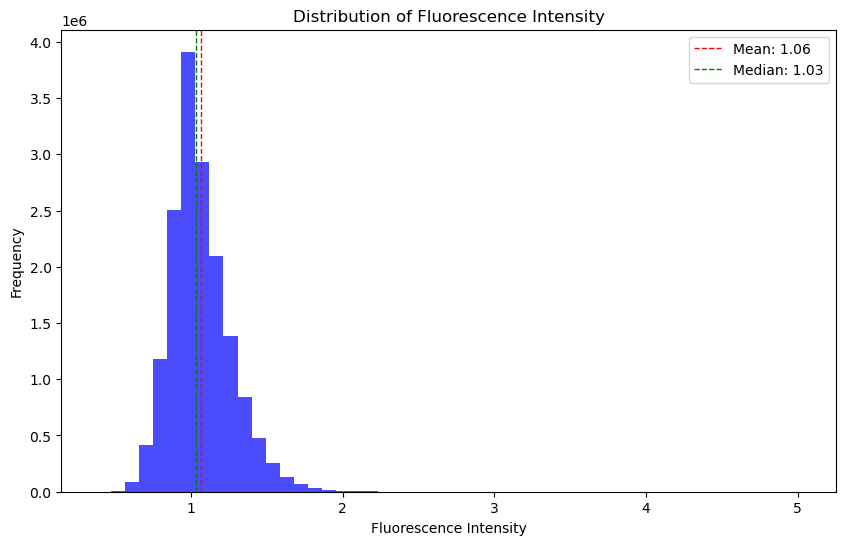

In [37]:
analyze_fluorescence_distribution(normalized_movie)

### Optionally, visualize the process and results with Napari

In [71]:
viewer = napari.Viewer()
viewer.add_image(movie_data, name="input movie", visible=False)
viewer.add_image(normalized_movie, name="normalized movie")
viewer.add_image(filtered_movie, name="filtered movie")
viewer.add_image(diff_movie, name="diff movie")
viewer.add_labels(threshold_movie, name="thresholded movie", opacity=0.5, visible=False)
viewer.add_labels(
    filtered_threshold_movie, name="filtered thresholded movie", opacity=0.7
)
viewer.add_points(
    [
        (
            int(spark["frame_number"]),
            int(spark["center_of_mass"][0]),
            int(spark["center_of_mass"][1]),
        )
        for spark in spark_coordinates
    ],
    name="candidate sparks",
    face_color="white",
    size=5,
)
viewer.add_points(
    [
        (
            int(spark["frame_number"]),
            int(spark["center_of_mass"][0]),
            int(spark["center_of_mass"][1]),
        )
        for spark in true_sparks
    ],
    name="true sparks",
    face_color="red",
    size=5,
    visible=False,
)

viewer.add_points(
    [
        (
            int(spark["frame_number"]),
            int(spark["center_of_mass"][0]),
            int(spark["center_of_mass"][1]),
        )
        for spark in true_sparks_wilcoxon
    ],
    name="true sparks wilcoxon",
    face_color="green",
    size=5,
)

<Points layer 'true sparks wilcoxon' at 0x226602d0f10>